### Web Scraping from Google Play Store with the help of 'google-play-scraper'

In [2]:
!pip install google_play_scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00


In [3]:
# pip install google-play-scraper pandas python-dateutil
from google_play_scraper import reviews_all, Sort
import pandas as pd
from dateutil import parser

APP_ID   = "co.hinge.app"
LANG     = "en"
COUNTRY  = "us"

print("Fetching reviews (newest first)...")
all_reviews = reviews_all(
    APP_ID,
    lang=LANG,
    country=COUNTRY,
    sort=Sort.NEWEST,
    sleep_milliseconds=200
)

df = pd.DataFrame(all_reviews)
# convert ’at’ to datetime if needed
if 'at' in df.columns:
    df['year'] = df['at'].apply(lambda d: d.year)
else:
    raise RuntimeError("Timestamp column 'at' not found – inspect library version")

# Filter to year = 2025
df_2025 = df[df['year'] == 2025].copy()
print(f"Found {len(df_2025)} reviews from 2025")

# Select key columns
cols = ['reviewId','userName','score','content','at','replyContent','thumbsUpCount','reviewCreatedVersion']
existing = [c for c in cols if c in df_2025.columns]
df_2025 = df_2025[existing]

# Save
csv_path = "hinge_play_reviews_2025.csv"
df_2025.to_csv(csv_path, index=False, encoding='utf-8')
print(f"Saved to {csv_path}")


Fetching reviews (newest first)...
Found 9093 reviews from 2025
Saved to hinge_play_reviews_2025.csv


# Loading the data

In [4]:
df = pd.read_csv("/content/hinge_play_reviews_2025.csv")
df.head()

,reviewId,userName,score,content,at,replyContent,thumbsUpCount,reviewCreatedVersion
0,8e1cd46b-1465-4718-b118-4a3326e9832c,A Google user,1,feel like it's all bots.,2025-10-18 23:02:50,NaN,0,9.95.0
1,b7f357e5-7a94-42bc-a2f2-fb140c072c6f,A Google user,1,Awful dating app. The idea of prompts encourag...,2025-10-18 22:55:29,NaN,2,NaN
2,6de05a64-366c-42d1-b9a2-854e0b21740b,A Google user,5,it's alright,2025-10-18 20:00:57,NaN,2,9.92.0
3,a80506a2-a1a6-4f93-a159-46a83f760360,A Google user,5,i found my person within 3 days of having the ...,2025-10-18 19:54:00,NaN,0,9.94.0
4,70b9da7c-3e48-44ee-9d4f-509fec56df57,A Google user,1,just not viable,2025-10-18 19:42:14,NaN,0,9.95.0


In [5]:
df.shape

(9093, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              9093 non-null   object
 1   userName              9093 non-null   object
 2   score                 9093 non-null   int64 
 3   content               9093 non-null   object
 4   at                    9093 non-null   object
 5   replyContent          509 non-null    object
 6   thumbsUpCount         9093 non-null   int64 
 7   reviewCreatedVersion  7082 non-null   object
dtypes: int64(2), object(6)
memory usage: 568.4+ KB


In [8]:
df.dtypes

,0
reviewId,object
userName,object
score,int64
content,object
at,object
replyContent,object
thumbsUpCount,int64
reviewCreatedVersion,object


### Check Missing Values

In [9]:
df.isna().sum()

,0
reviewId,0
userName,0
score,0
content,0
at,0
replyContent,8584
thumbsUpCount,0
reviewCreatedVersion,2011


In [10]:
df = df.drop(columns=['replyContent'])

In [11]:
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].fillna('unknown')

In [13]:
df.head()

,reviewId,userName,score,content,at,thumbsUpCount,reviewCreatedVersion
0,8e1cd46b-1465-4718-b118-4a3326e9832c,A Google user,1,feel like it's all bots.,2025-10-18 23:02:50,0,9.95.0
1,b7f357e5-7a94-42bc-a2f2-fb140c072c6f,A Google user,1,Awful dating app. The idea of prompts encourag...,2025-10-18 22:55:29,2,unknown
2,6de05a64-366c-42d1-b9a2-854e0b21740b,A Google user,5,it's alright,2025-10-18 20:00:57,2,9.92.0
3,a80506a2-a1a6-4f93-a159-46a83f760360,A Google user,5,i found my person within 3 days of having the ...,2025-10-18 19:54:00,0,9.94.0
4,70b9da7c-3e48-44ee-9d4f-509fec56df57,A Google user,1,just not viable,2025-10-18 19:42:14,0,9.95.0


### Normalize the text

In [16]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=cd028ca2e75174e6b3f78ba432675f130ea145bc1a78712027d207348bf8ca54
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [17]:
import re
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # for reproducibility

In [18]:
def clean_text(text):
    text = str(text)
    text = text.encode('utf-8', 'ignore').decode('utf-8')  # ensure utf-8
    text = re.sub(r'\s+', ' ', text)                       # collapse spaces/newlines
    text = text.strip()
    return text

df['content_clean'] = df['content'].apply(clean_text)

### Converting into proper Datatypes

In [21]:
df['at'] = pd.to_datetime(df['at'])
df['score'] = pd.to_numeric(df['score'])
df['thumbsUpCount'] = pd.to_numeric(df['thumbsUpCount'])

In [22]:
df = df.sort_values('at', ascending=False)
df.to_csv("hinge_reviews_clean.csv", index=False)

### Classification

Classification at this stage is done without the implementation of ML approach.

In [6]:
import pandas as pd
import re

In [3]:
df2 = pd.read_csv('/content/hinge_reviews_clean.csv')
df2

,reviewId,userName,score,content,at,thumbsUpCount,reviewCreatedVersion,content_clean
0,8e1cd46b-1465-4718-b118-4a3326e9832c,A Google user,1,feel like it's all bots.,2025-10-18 23:02:50,0,9.95.0,feel like it's all bots.
1,b7f357e5-7a94-42bc-a2f2-fb140c072c6f,A Google user,1,Awful dating app. The idea of prompts encourag...,2025-10-18 22:55:29,2,unknown,Awful dating app. The idea of prompts encourag...
2,6de05a64-366c-42d1-b9a2-854e0b21740b,A Google user,5,it's alright,2025-10-18 20:00:57,2,9.92.0,it's alright
3,a80506a2-a1a6-4f93-a159-46a83f760360,A Google user,5,i found my person within 3 days of having the ...,2025-10-18 19:54:00,0,9.94.0,i found my person within 3 days of having the ...
4,70b9da7c-3e48-44ee-9d4f-509fec56df57,A Google user,1,just not viable,2025-10-18 19:42:14,0,9.95.0,just not viable
...,...,...,...,...,...,...,...,...
9088,bf70624c-e27f-4da4-a609-903ef029626b,A Google user,1,ridiculous app anyone can go around reporting ...,2025-01-01 06:14:58,3,9.43.0,ridiculous app anyone can go around reporting ...
9089,30f91e3f-7aba-40f2-9559-3459806f8c24,A Google user,1,you can't put a price on love. and you charge ...,2025-01-01 05:17:42,1,9.64.0,you can't put a price on love. and you charge ...
9090,4bcae9fb-fcb9-4679-930f-fccedc7dfc2d,A Google user,1,Made a new account but my old phone number isn...,2025-01-01 04:32:36,1,9.64.0,Made a new account but my old phone number isn...
9091,f30705e5-8f01-45c9-9bfc-1a1a2a3fd0b8,A Google user,1,this app sucks,2025-01-01 02:46:17,2,9.64.0,this app sucks


## Rule-Based Intent Classification

As the initial step for **Intent Classification**, we implement a simple **rule-based classifier** using a predefined dictionary of keywords (`INTENT_KEYWORDS`).

This method serves as a fast, interpretable baseline to understand the immediate distribution of user intents (Bugs, Suggestions, Criticism, Positive, Questions, Spam). The classification function iterates through the keywords and assigns the first matching intent to the review's content (after cleaning and lowercasing). The use of the `\b` word boundary in the regex ensures that only whole words are matched, reducing false positives.

In [8]:
# Keywords for intents
INTENT_KEYWORDS = {
    "bug": [
        "crash", "error", "bug", "glitch", "not working", "freeze",
        "stuck", "slow", "lag", "won't load", "login", "issue", "problem"
    ],
    "suggestion": [
        "should", "please add", "would be nice", "feature", "add option",
        "wish", "request", "improve", "suggest", "maybe allow", "hope you can"
    ],
    "criticism": [
        "terrible", "worst", "fake", "waste", "scam", "disappoint",
        "bad", "poor", "hate", "awful", "uninstall", "useless", "boring"
    ],
    "positive": [
        "love", "great", "awesome", "amazing", "good", "perfect",
        "nice", "fantastic", "best", "wonderful", "met someone", "works well"
    ],
    "question": [
        "how do i", "how can i", "why", "where", "can you", "is there a way",
        "?", "help me", "anyone know", "what if"
    ],
    "spam": [
        "check my profile", "click", "link", "visit", "http", "www",
        "earn money", "promo", "discount", "download", "follow me"
    ],
}

# Simple matching function
def classify_intent(text):
    text = str(text).lower()

    for intent, keywords in INTENT_KEYWORDS.items():
        for kw in keywords:
            if re.search(r"\b" + re.escape(kw) + r"\b", text):
                return intent

    # default fallback
    return "neutral_or_other"

# Apply classification
df2["intent"] = df2["content_clean"].apply(classify_intent)

# group stats
intent_counts = df2["intent"].value_counts()
print(intent_counts)


intent
neutral_or_other    4432
criticism           1839
positive            1589
suggestion           431
bug                  404
question             344
spam                  54
Name: count, dtype: int64


### Sentiment Analysis

In [9]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


## Sentiment Analysis with VADER

To establish an initial baseline for **Sentiment Analysis**, we will use **VADER** (Valence Aware Dictionary and sEntiment Reasoner). VADER is a rule-based model specifically attuned to sentiments expressed in social media text (e.g., emojis, slang) and does not require training.

It generates four scores: `neg`, `neu`, `pos`, and a composite score (`compound`). We use the **`compound`** score to classify reviews into three simple categories:

* **Positive**: `compound` score $\ge 0.05$
* **Neutral**: `compound` score between $-0.05$ and $0.05$
* **Negative**: `compound` score $\le -0.05$


In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define classification function
def get_sentiment(text):
    if not isinstance(text, str):
        return "neutral"
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Apply to dataset
df2['sentiment'] = df2['content_clean'].apply(get_sentiment)

# Verify distribution
print("Sentiment distribution:")
print(df2['sentiment'].value_counts(normalize=True).round(2))


Sentiment distribution:
sentiment
positive    0.43
negative    0.43
neutral     0.14
Name: proportion, dtype: float64


In [12]:
df2.to_csv("hinge_reviews_final.csv")

## Exploratory Data Analysis

### Visulaizing Ratings Distribution

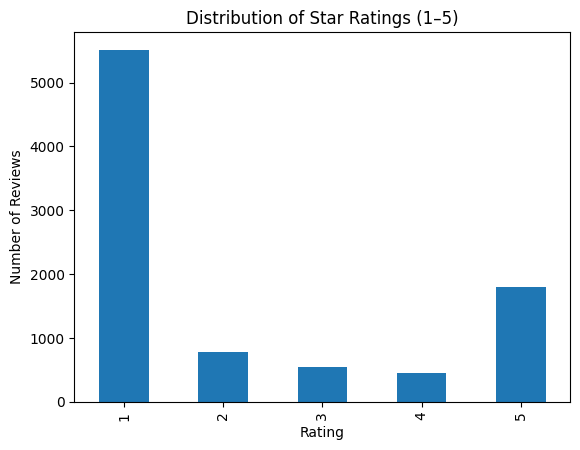

In [14]:
import matplotlib.pyplot as plt

df2['score'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Star Ratings (1–5)")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

### Sentiment Distribution

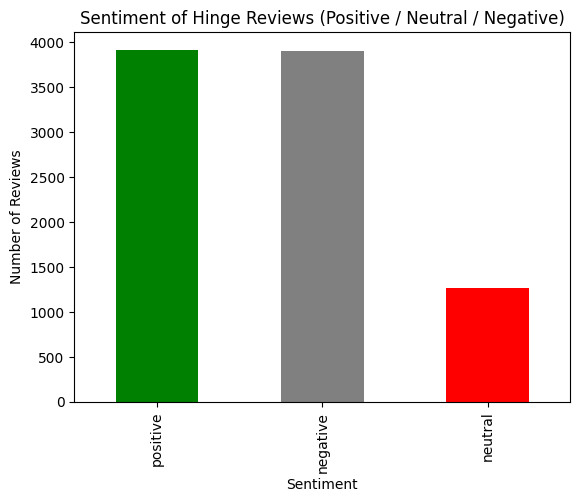

In [18]:
df2['at'] = pd.to_datetime(df2['at'], errors='coerce')

df2['sentiment'].value_counts().plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("Sentiment of Hinge Reviews (Positive / Neutral / Negative)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

### Sentiment Over Time

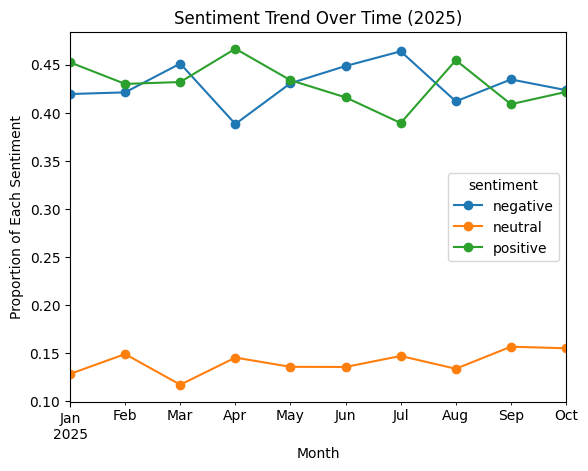

In [20]:
df2['month'] = df2['at'].dt.to_period('M')
sent_trend = df2.groupby('month')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
sent_trend.plot(kind='line', marker='o')
plt.title("Sentiment Trend Over Time (2025)")
plt.ylabel("Proportion of Each Sentiment")
plt.xlabel("Month")
plt.show()
